# Nonparametric Differential Equations (npde)

This document describes how to use the software implementation of our **npsde** (nonparametric stochastic differential equations) model. The implementation is in python3.5 and requires __[TensorFlow(1.6.0+)](https://www.tensorflow.org/)__ and __[GPflow(1.1+)](https://github.com/GPflow/GPflow)__. To learn more about the model, __[here](https://arxiv.org/abs/1807.05748)__ is a link to the our paper to be presented in MLSP in September 2018. This repository also overrides the MATLAB implementation of **npODE** model for learning ordinary differential equations (__[here](http://proceedings.mlr.press/v80/heinonen18a/heinonen18a.pdf)__ is the npODE ICML 2018 paper and __[here](https://github.com/cagatayyildiz/npode)__ is the old MATLAB implementation).

&nbsp;

**Notebook Sections**

The notebook consists of three sections, each containing an example fit where the underlying dynamics are governed by an ODE, SDE with constant diffusion, and SDE with state dependent diffusion. Van der Pol (VDP) oscillator, whose dynamics are given by equations below, is used as the running example:
\begin{align*}
\frac{dx_1}{dt} = x_2 \qquad \qquad \frac{dx_2}{dt} &= (1-x_1^2) x_2 - x_1 
\end{align*}
In examples below, true constant diffusion is equal to 0.2 and the state dependent diffusion function is given by $g(x)=3\mathcal{N}(x;[-2,0],0.5I)$. The model is completely unaware of the dynamics, and infers the dynamics by placing Gaussian process priors over the drift and diffusion functions and computing the posterior.

&nbsp;

**Main Functions**

There are three main python functions that provide an easy-to-use interface to the model implementation:
 * ```npde_fit``` -  fits the model (ODE/SDE) to the input data and observed time points  
 * `predict` - a class function that predicts signals given a `npde` model that stores the learned SDE dynamics, an initial value and observed time points   
 * `sample` - a class function that draws samples from a learned SDE system signals given the same input in `predict` function

&nbsp;

**For Better Performance**

The quality of the fit relies on many factors including the width of the inducing point grid `W`, lengthscales `ell`, learning rate `eta`, number of optimization steps `num_iter` and number of samples `Nw` used for optimization in SDEs. Few notes about enhancing the performance: 
 * In general, a denser inducing point grid and more samples for SDEs are better - the higher `W` and `Nw`, the better. 
 * Learning rate must always be carefully tuned for every problem and even data set.
 * Higher lengthscale values result in smoother trajectories. Although optimized, we reserve it for model selection. For example in modeling constant diffusions, lengthscale of the diffusion function must be high, e.g., $10^5$. It is also a good idea to perform the optimization several times over a grid of lengthscales. For instance, a good grid in case of VDP oscillator with `W=5` would be `linspace(0.75,4,10`).
 * It should also be noted that `W` and `ell` should be tuned together carefully. In general, if one is increased, then the other should be decreased.

## Preparing the Environment

In [35]:
%load_ext autoreload
%autoreload 2

# avoid GPU due to Cholesky decompositions
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 1.x
import tensorflow as tf

sess = tf.InteractiveSession()

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Run once to clone repo:

In [ ]:
#from google.colab import drive
#drive.mount("/content/gdrive")
#%cd gdrive/MyDrive/EstimatingSDE
#! git clone https://github.com/marghetis/npde
#! git pull


Run every time to load GDrive repo, and pull changes from Github:

In [36]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/MyDrive/EstimatingSDE/npde
!git fetch --all
!git reset --hard origin/master
!git pull

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/EstimatingSDE/npde'
/content/gdrive/MyDrive/EstimatingSDE/npde
Fetching origin
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.
From https://github.com/marghetis/npde
   4e20ca5..829ca9f  master     -> origin/master
HEAD is now at 829ca9f Created using Colaboratory
Already up to date.


In [37]:
!pip install gpflow==1.1
import gpflow
from utils import gen_data, plot_model
from npde_helper import build_model, fit_model, save_model, load_model


In [38]:
!pip install latex
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
texlive is already the newest version (2017.20180305-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


## 1. ODE

### Data Generation

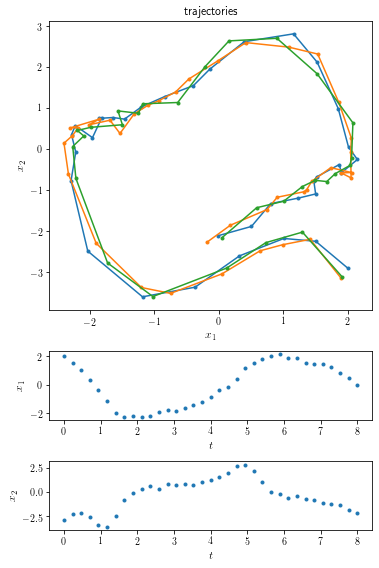

In [39]:
np.random.seed(918273) # just for illustration purposes
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35,40,30], tend=8, nstd=0.1)

###  Inference

noise variance:        [0.005501   0.01281601]
signal variance:       1.5623948816326665
lengthscales:          [0.81737374 1.25432704]


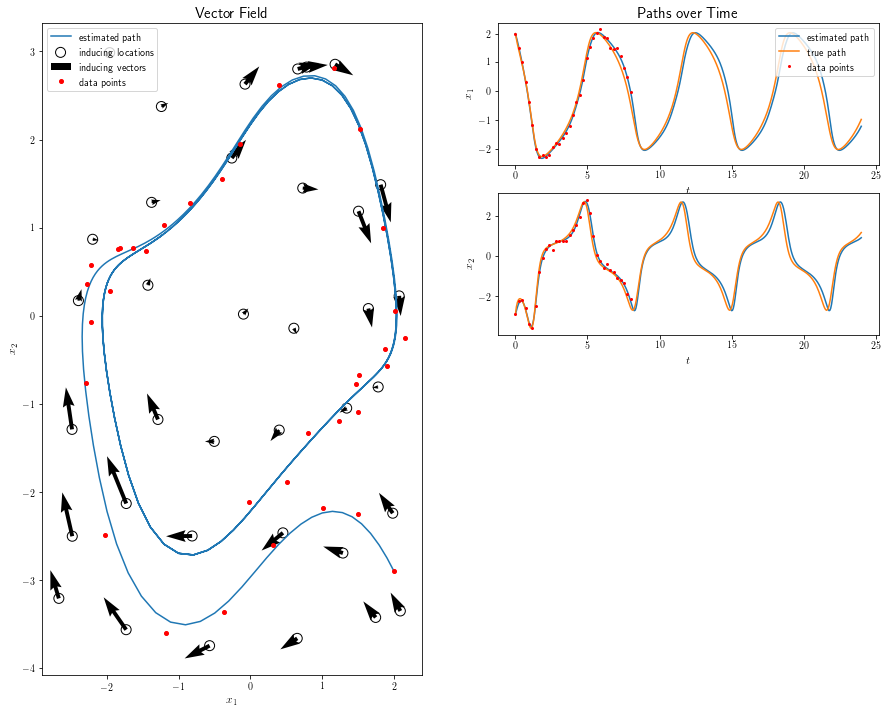

In [ ]:
# t - observation times, a python array of numpy vectors
# Y - observations, a python array of numpy matrices, data points are in rows
# step size (eta) must be carefully tuned for different data sets
npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")
npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)

# how to plot the model
# plot_model(npde,t,Y)

# how to save/load the model
# save_model(npde,'npde.pkl')
# npde = load_model('npde.pkl',sess)

## 2. SDE with Constant Diffusion

### Data Generation

In [78]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-cdiff', Ny=[35,40,30], tend=8, nstd=0.1)

array([[ 2.        , -3.        ],
       [ 1.24641578, -2.05215531],
       [ 0.68673364, -2.23450984],
       [-0.1695334 , -2.97816905],
       [-1.23387871, -3.37391778],
       [-2.04601982, -1.78514504],
       [-2.38015131, -0.15590839],
       [-2.30052285,  0.35568071],
       [-2.05963943,  0.6067756 ],
       [-1.92920501,  0.65936275],
       [-1.76006323,  0.491899  ],
       [-1.57636734,  0.71166347],
       [-1.26596102,  0.9348023 ],
       [-0.90200264,  1.38931692],
       [-0.53550132,  1.80207692],
       [ 0.18712928,  2.55196587],
       [ 0.88267959,  3.15412496],
       [ 1.78708199,  2.49160942],
       [ 2.21423207,  0.67385801],
       [ 2.39423687, -0.20217484],
       [ 2.25505554, -0.3066577 ],
       [ 1.96855976, -0.38969661],
       [ 1.87614423, -0.64070848],
       [ 1.51182303, -0.78803917],
       [ 1.34100193, -0.95759227],
       [ 0.94313099, -1.25671273],
       [ 0.57358988, -1.7485343 ],
       [ 0.09534753, -2.42426027],
       [-0.7406265 ,

### Inference

In [79]:
# in order to constant diffusion, lengthscale of the diffusion process (ellg0) must be initialized to a big number
npde = build_model(sess, t, Y, model='sde', sf0=1.0, ell0=np.ones(2), W=6, ellg0=[1e5], ktype="id")
npde = fit_model(sess, npde, t, Y, Nw=100, num_iter=1000, print_every=50, eta=0.02, plot_=False)

array([array([0.        , 0.23529412, 0.47058824, 0.70588235, 0.94117647,
              1.17647059, 1.41176471, 1.64705882, 1.88235294, 2.11764706,
              2.35294118, 2.58823529, 2.82352941, 3.05882353, 3.29411765,
              3.52941176, 3.76470588, 4.        , 4.23529412, 4.47058824,
              4.70588235, 4.94117647, 5.17647059, 5.41176471, 5.64705882,
              5.88235294, 6.11764706, 6.35294118, 6.58823529, 6.82352941,
              7.05882353, 7.29411765, 7.52941176, 7.76470588, 8.        ]),
       array([0.        , 0.20512821, 0.41025641, 0.61538462, 0.82051282,
              1.02564103, 1.23076923, 1.43589744, 1.64102564, 1.84615385,
              2.05128205, 2.25641026, 2.46153846, 2.66666667, 2.87179487,
              3.07692308, 3.28205128, 3.48717949, 3.69230769, 3.8974359 ,
              4.1025641 , 4.30769231, 4.51282051, 4.71794872, 4.92307692,
              5.12820513, 5.33333333, 5.53846154, 5.74358974, 5.94871795,
              6.15384615, 6.35897436

### Predictions

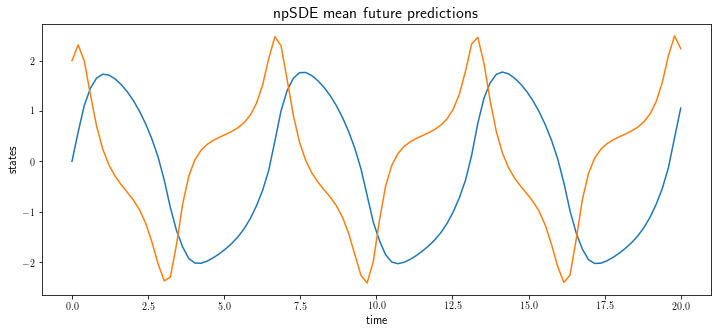

In [ ]:
x0 = [0,2] # initial value
t = np.linspace(0,20,100) # time points 
path = npde.predict(x0,t)
path = sess.run(path)

plt.figure(figsize=(12,5))
plt.plot(t,path)
plt.xlabel('time',fontsize=12)
plt.ylabel('states',fontsize=12)
plt.title('npSDE mean future predictions',fontsize=16);

### Sampling

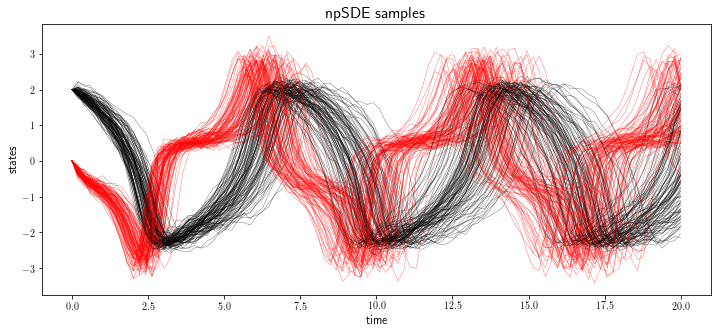

In [ ]:
x0 = [2,0]
t = np.linspace(0,20,100)
Nw = 100 # number of samples
samples = npde.sample(x0,t,Nw=100)
samples = sess.run(samples)

plt.figure(figsize=(12,5))
for i in range(Nw):
    plt.plot(t,samples[i,:,0],'-k',linewidth=0.25)
    plt.plot(t,samples[i,:,1],'-r',linewidth=0.25)
plt.xlabel('time',fontsize=12)
plt.ylabel('states',fontsize=12)
plt.title('npSDE samples',fontsize=16);
plt.savefig('samples.png', dpi=200)

## 3. SDE with State Dependent Diffusion

### Data Generation

In [75]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-sdiff', Ny=[40,30,40,30,30], tend=8, nstd=0.1)

array([[ 2.        , -3.        ],
       [ 1.31887945, -2.08787622],
       [ 0.73544755, -2.26903714],
       [ 0.04551728, -2.91902153],
       [-0.84617961, -3.58565824],
       [-1.788472  , -2.69805094],
       [-2.29014431, -0.64531273],
       [-2.34464292,  0.23309627],
       [-2.2490075 ,  0.45763241],
       [-2.11222924,  0.54181148],
       [-1.95552176,  0.60619436],
       [-1.78039453,  0.67946793],
       [-1.58280508,  0.77511095],
       [-1.35500028,  0.90821939],
       [-1.08421608,  1.10263924],
       [-0.74954198,  1.39710716],
       [-0.31769832,  1.84154953],
       [ 0.2546263 ,  2.42170602],
       [ 0.97441337,  2.74605737],
       [ 1.67242907,  1.95836558],
       [ 2.04942932,  0.56443901],
       [ 2.1043614 , -0.19162116],
       [ 2.01451915, -0.46931495],
       [ 1.86914535, -0.59878983],
       [ 1.69254514, -0.70081983],
       [ 1.48680056, -0.81766135],
       [ 1.24485673, -0.97572965],
       [ 0.95208542, -1.20688957],
       [ 0.58361071,

### Inference

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1        1014.740
              50         549.409
             100         475.902
             150         468.575
             200         482.402
             250         401.282
             300         376.192
             350         356.975
             400         363.786
             450         332.174
             500         329.895
             550         357.319
             600         323.728
             650         312.710
             700         332.637
             750         297.416
             800         339.565
             850         333.552
             900         321.648
             950         338.940
            1000         379.446
Optimization ends.
Plotting...
noise variance:        [0.04185838 0.03544848]
signal variance:       1.3989643024994938
lengthscales:          [0.90235335 1.0576399

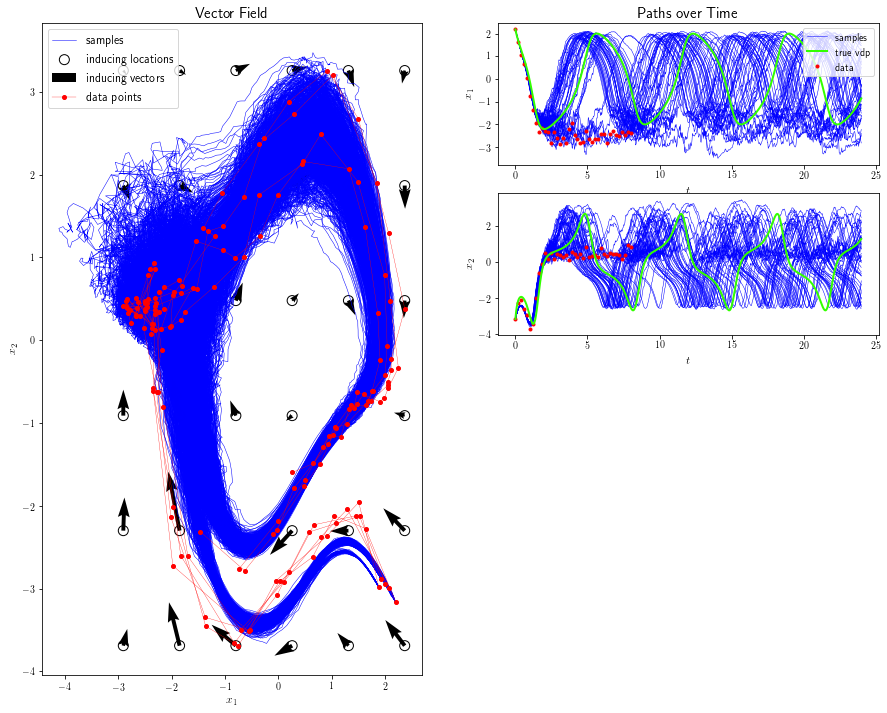

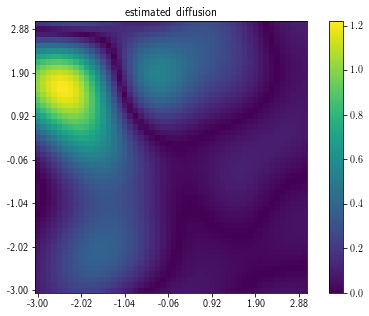

In [ ]:
npde = build_model(sess, t, Y, model='sde', sf0=1.0, ell0=np.ones(2), W=6, ellg0=[1.0], ktype="id", fix_Z=True)
npde = fit_model(sess, npde, t, Y, Nw=50, num_iter=1000, print_every=50, eta=0.01, plot_=True)

#Lorenz

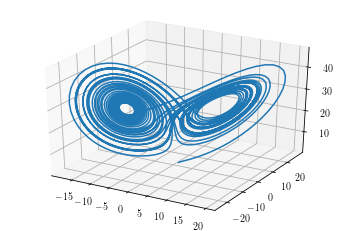

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states1 = odeint(f, state0, t)
states2 = odeint(f, state0, t)
states3 = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

In [68]:
# t - observation times, a python array of numpy vectors
# Y - observations, a python array of numpy matrices, data points are in rows
# step size (eta) must be carefully tuned for different data sets
len(t)
states[0]
Y
lorenz_npde = build_model(sess, t, states, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")
npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)

array([array([[ 1.99899225, -2.90441268],
              [ 1.50145248, -2.24758418],
              [ 1.00702274, -2.17893058],
              [ 0.32055394, -2.60338895],
              [-0.36742804, -3.36807244],
              [-1.18187709, -3.60259388],
              [-2.02950283, -2.48762767],
              [-2.28883885, -0.76831998],
              [-2.2159523 , -0.07117989],
              [-2.28152192,  0.35508902],
              [-2.22248613,  0.57491198],
              [-1.95687766,  0.28160419],
              [-1.8114657 ,  0.7719148 ],
              [-1.84811478,  0.75199908],
              [-1.64034006,  0.77265032],
              [-1.4603875 ,  0.73334931],
              [-1.1986254 ,  1.03246691],
              [-0.84083195,  1.28227753],
              [-0.3931522 ,  1.55178576],
              [-0.13932894,  1.95318008],
              [ 0.39348916,  2.62241744],
              [ 1.15766088,  2.8143773 ],
              [ 1.52341134,  2.1236581 ],
              [ 1.8504515 ,  0.990